### Import Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords 
import string , nltk

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
import warnings
ignore_warnings = True
if ignore_warnings:
    warnings.filterwarnings("ignore")


### Read Data

In [2]:
# Read Data
dv__df = pd.read_csv("/Users/darylwanji/Desktop/SexismDetection/archive/dev.csv")
train_df = pd.read_csv("/Users/darylwanji/Desktop/SexismDetection/archive/train (2).csv")
test_df = pd.read_csv("/Users/darylwanji/Desktop/SexismDetection/archive/test (1).csv")

sexism_df = pd.concat([dv__df, train_df, test_df], ignore_index=True)

sexism_df.sample(10)

,rewire_id,text,label_sexist,label_category,label_vector,split
8822,sexism2022_english-3506,"Nah, she was a feminist and it didn't sound li...",not sexist,none,none,train
14780,sexism2022_english-16665,I PRAY THAT MORE AMERICANS WILL REALIZE HOW CR...,not sexist,none,none,train
3311,sexism2022_english-9768,This girl's pretty fucking smart and on the mo...,not sexist,none,none,train
17097,sexism2022_english-1009,Wow. All the first responses are about evil wo...,not sexist,none,none,test
15493,sexism2022_english-2121,Christians: Stop your whimpering about Trump’s...,not sexist,none,none,train
10844,sexism2022_english-18592,"The feminists, family court, #me-too, and divo...",sexist,4. prejudiced discussions,4.2 supporting systemic discrimination against...,train
11996,sexism2022_english-17212,until she divorce rapes him.,sexist,4. prejudiced discussions,4.2 supporting systemic discrimination against...,train
348,sexism2022_english-16447,True. ALL women are escorts except for when th...,sexist,2. derogation,2.1 descriptive attacks,dev
14331,sexism2022_english-9683,I know all about student loans... I paid My la...,not sexist,none,none,train
8482,sexism2022_english-16238,What I like to do is send the dick pic from a ...,sexist,"1. threats, plans to harm and incitement",1.2 incitement and encouragement of harm,train


> 1 - At a glance, the data is clean with no null values        
> 2 - rewire_id needs some cleaning as there are some unnecessary characters        
> 3 - Some columns needs to be renamed for better understanding     

In [3]:
sexism_df = sexism_df.rename(columns={"rewire_id": "ID",
                                       "text": "Text", 
                                       "label_sexist": "Sexism", 
                                       "label_category": "Category", 
                                       "label_vector": "Rationale", 
                                       "split": "Split"})

In [4]:
sexism_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         20000 non-null  object
 1   Text       20000 non-null  object
 2   Sexism     20000 non-null  object
 3   Category   20000 non-null  object
 4   Rationale  20000 non-null  object
 5   Split      20000 non-null  object
dtypes: object(6)
memory usage: 937.6+ KB


> 6 columns: rewire_id, text, label_sexist, label_category, label_vector, split  
> # Data Description
> ID : is the unique identifier for each row     
> Text : The English text for analysis.     
> Sexism : is the label for whether the text is sexist or not     
> Category : Type of sexist remarks     
> Rationale : Details on the sexist remarks     
> Split : Merged dataset split (train, dev, test)
>
> 
> 20000 rows     
> All 20000 rows no null values

In [5]:
print(f"Sexism labels: {len(sexism_df['Sexism'].unique())}\n")
print(f"Category labels: {len(sexism_df['Category'].unique())}\n")
print(f"Rationale labels: {len(sexism_df['Rationale'].unique())}\n")
print(f"Split labels: {len(sexism_df['Split'].unique())}\n")


Sexism labels: 2

Category labels: 5

Rationale labels: 12

Split labels: 3



> There are 2 unique labels for Sexism (sexist, not sexist)         
> There are 5 unique labels for Category        
> There are 5 unique labels for Rationale       
> There is 3 unique label for Splits (train, dev, test)         

### Sanity Check

In [6]:
print(sexism_df.groupby("Sexism").count(), "\n")

print(sexism_df.groupby("Category").count(), "\n")

print(sexism_df.groupby("Rationale").count(), "\n")

print(sexism_df.groupby("Split").count(), "\n")


               ID   Text  Category  Rationale  Split
Sexism                                              
not sexist  15146  15146     15146      15146  15146
sexist       4854   4854      4854       4854   4854 

                                             ID   Text  Sexism  Rationale  \
Category                                                                    
1. threats, plans to harm and incitement    443    443     443        443   
2. derogation                              2271   2271    2271       2271   
3. animosity                               1665   1665    1665       1665   
4. prejudiced discussions                   475    475     475        475   
none                                      15146  15146   15146      15146   

                                          Split  
Category                                         
1. threats, plans to harm and incitement    443  
2. derogation                              2271  
3. animosity                               166

In [7]:
sexism_df

,ID,Text,Sexism,Category,Rationale,Split
0,sexism2022_english-9609,"In Nigeria, if you rape a woman, the men rape ...",not sexist,none,none,dev
1,sexism2022_english-966,I bet she wished she had a gun,not sexist,none,none,dev
2,sexism2022_english-3553,I agree with that but at the same time I know ...,sexist,2. derogation,2.1 descriptive attacks,dev
3,sexism2022_english-13328,democrats from Minnesota (leftist muzzie shith...,sexist,2. derogation,2.2 aggressive and emotive attacks,dev
4,sexism2022_english-81,Texas jury sentences Jordanian immigrant to de...,not sexist,none,none,dev
...,...,...,...,...,...,...
19995,sexism2022_english-2356,Define blatant. If you're with a girl then be ...,not sexist,none,none,test
19996,sexism2022_english-17641,Take a look at mgtow. Even chads know women ar...,sexist,2. derogation,2.1 descriptive attacks,test
19997,sexism2022_english-6358,When you're known as the guy who argues that w...,not sexist,none,none,test
19998,sexism2022_english-8770,You should’ve asked if you could be her side p...,not sexist,none,none,test


### Data Transformation

In [8]:
# Extract the ID from the 'ID' column
sexism_df['ID'] = sexism_df['ID'].str.extract(r'sexism2022_english-([0-9]*)', expand=False)
# Map the 'Sexism' column to 1 and 0
sexism_df['Sexism'] = sexism_df['Sexism'].map({'sexist': 1, 'not sexist': 0})
sexism_df.sample(10)

,ID,Text,Sexism,Category,Rationale,Split
9799,6958,Le special snowflake,0,none,none,train
2286,2334,"[URL] Hu'tegh SoHvaD pagh maQam! 'oH wIghaj, l...",0,none,none,train
1396,9963,[URL] Illegal Muslim Immigrant Who Killed Jews...,0,none,none,dev
10052,10961,the female rapists are so scummy they will hav...,0,none,none,train
7748,14328,She came up to me about 5 metres away from whe...,0,none,none,train
6890,883,You mean like that sweet motorcycle she totall...,0,none,none,train
285,18547,Can women be loyal? If you make them loyal. Ju...,1,2. derogation,2.1 descriptive attacks,dev
14331,9683,I know all about student loans... I paid My la...,0,none,none,train
301,4072,The white beuty thing really fucking triggered...,0,none,none,dev
19014,17889,Most women are Leftists. and all left paradigm...,1,4. prejudiced discussions,4.2 supporting systemic discrimination against...,test


In [9]:
sexism_df.describe()
sexism_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         20000 non-null  object
 1   Text       20000 non-null  object
 2   Sexism     20000 non-null  int64 
 3   Category   20000 non-null  object
 4   Rationale  20000 non-null  object
 5   Split      20000 non-null  object
dtypes: int64(1), object(5)
memory usage: 937.6+ KB


In [10]:
sexism_df.isnull().sum()

ID           0
Text         0
Sexism       0
Category     0
Rationale    0
Split        0
dtype: int64

In [11]:
sexism_df.duplicated().sum()

0

> No duplicates


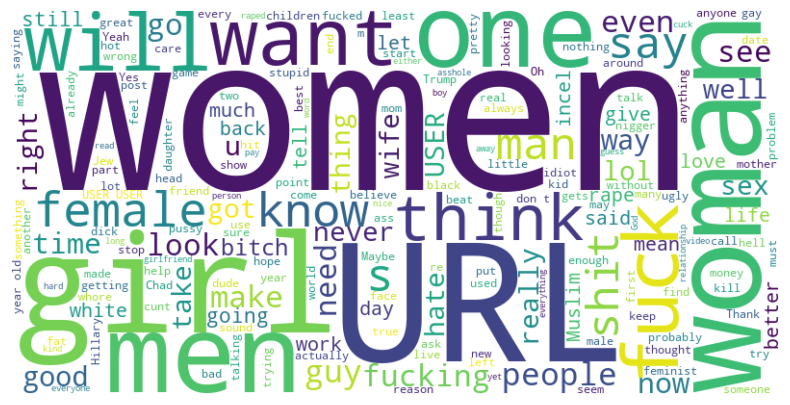

In [12]:
# World Cloud for all the text
text = ' '.join(sexism_df['Text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

> Word Cloud suggest that the text data is mainly about women and their body and contains some slurs

In [13]:
# Save the data
sexism_df.to_csv("/Users/darylwanji/Desktop/SexismDetection/archive/sexism_df.csv", index=False)

### Preprocessing


In [14]:
# Split the data into train, test, dev (They were split in the original dataset) 
train_df, test_df, dev_df = sexism_df[sexism_df['Split'] == 'train'], sexism_df[sexism_df['Split'] == 'test'], sexism_df[sexism_df['Split'] == 'dev']

# Check if the columns are the same
print(train_df.columns ==  test_df.columns)
print(test_df.columns == dev_df.columns)

[ True  True  True  True  True  True]
[ True  True  True  True  True  True]


In [15]:

ENGLISH_STOP_WORDS = stopwords.words('english')
stemmer = nltk.stem.PorterStemmer()

def my_tokenizer(sentence):
    """
    Tokenizer function to remove punctuation, set to lower case, remove stopwords and stem words
    sentence: strs
    """
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

In [16]:
# Train Vectorizer on train_df, test_df and dev_df
bagofwords_p = CountVectorizer(
    stop_words='english',
    max_features=5000,
    min_df=10,
    tokenizer=my_tokenizer
)

# Fit the vectorizer on the train_df
bagofwords_p.fit(train_df['Text'])

train_df_transformed = bagofwords_p.transform(train_df['Text'])
test_df_transformed = bagofwords_p.transform(test_df['Text'])
dev_df_transformed = bagofwords_p.transform(dev_df['Text'])

print("Vocabulary size:", len(bagofwords_p.vocabulary_))
print("Transformed shape:", train_df_transformed.shape)


Vocabulary size: 2251
Transformed shape: (14000, 2251)


In [17]:
train_df_transformed_matrix = pd.DataFrame(train_df_transformed.toarray(),
                                            columns=bagofwords_p.get_feature_names_out(),
                                            index=train_df['Text'])
test_df_transformed_matrix = pd.DataFrame(test_df_transformed.toarray(),
                                           columns=bagofwords_p.get_feature_names_out(),
                                           index=test_df['Text'])
dev_df_transformed_matrix = pd.DataFrame(dev_df_transformed.toarray(),
                                          columns=bagofwords_p.get_feature_names_out(),
                                          index=dev_df['Text'])

train_df_transformed_matrix.sample(10)

,0,1,10,100,1000,11,12,13,14,15,...,yr,yup,zero,zone,–,—,“i,…,😂,🤔
Text,,,,,,,,,,,,,,,,,,,,,
Nope this is syill the samr behavipur I'm looking for! You badically said if a girl is hot enough a guy will cheat on the spot and vice versa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"I don't even want one wife, much less this: [URL]",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"#BREAKING: Attorney Michael Avenatti reveals third woman to accuse Kavanaugh of sexual assault, Julie Swetnick [URL]",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Serves them right. Hatians n Somolians dumbest people on the planet. Those are the only 2 groups of people who should be banned 100% from our country. BTW Holland took in Ayn Hersi Ali but somehow America ended up w/her. Whhyyyyyy!??!??,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"And we meet again. Just installed a Buderus boiler with a Riello burner and in the process of installing radiant floor heat. Spendy, but so is $7 gal heating fuel.",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Maybe it's all the creepypasta I've been listening to as of late, but i would like to introduce her face to wall construed out of a fundamental building material.",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Original link here, complete with ""arty"" photographs of the mutilator hard at work: [URL] This article is so full of utter evil filth, it's hard to know where to start. God help all these infant boys she is raping, mutilating and sexually abusing.",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Nancy Sinatra calling for the slaughter of gun owners, she's as bad as the mass murderers. Democrats need to be caged!! Nancy Sinatra Calls for Millions of NRA Members to be Killed by Firing Squad - [URL]",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
I dont think its as straight narrow or clear cut as you said. Some women will ghost for attention. Like a cry for help,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
train_df_transformed_matrix.sum().sort_values(ascending=False).head(10)
train_df_transformed_matrix.columns

Index(['0', '1', '10', '100', '1000', '11', '12', '13', '14', '15',
       ...
       'yr', 'yup', 'zero', 'zone', '–', '—', '“i', '…', '😂', '🤔'],
      dtype='object', length=2251)

In [19]:
new_train_df = pd.concat([train_df.reset_index(drop=True), train_df_transformed_matrix.reset_index(drop=True)], axis=1)
new_train_df = new_train_df.drop(columns=['Text','Rationale','Split','ID'])  # Dropping the text column as it is not needed for modelling
new_train_df = pd.get_dummies(new_train_df,columns=['Category'],prefix='Cat_')# One Hot Encoding for Category


new_test_df = pd.concat([test_df.reset_index(drop=True), test_df_transformed_matrix.reset_index(drop=True)], axis=1)
new_test_df = new_test_df.drop(columns=['Text','Rationale','Split','ID'])  # Dropping the text column as it is not needed for modelling
new_test_df = pd.get_dummies(new_test_df,columns=['Category'],prefix='Cat_') # One Hot Encoding for Category

new_dev_df = pd.concat([dev_df.reset_index(drop=True), dev_df_transformed_matrix.reset_index(drop=True)], axis=1)
new_dev_df = new_dev_df.drop(columns=['Text','Rationale','Split','ID'])  # Dropping the text column as it is not needed for modelling
new_dev_df = pd.get_dummies(new_dev_df,columns=['Category'],prefix='Cat_') # One Hot Encoding for Category

new_train_df.columns


Index(['Sexism', '0', '1', '10', '100', '1000', '11', '12', '13', '14',
       ...
       '—', '“i', '…', '😂', '🤔',
       'Cat__1. threats, plans to harm and incitement', 'Cat__2. derogation',
       'Cat__3. animosity', 'Cat__4. prejudiced discussions', 'Cat__none'],
      dtype='object', length=2257)

### Modelling 


In [20]:
# For training
X_train = new_train_df.drop(columns=['Sexism','Cat__none'])
y_train = new_train_df['Sexism']

# For testing
X_test = new_test_df.drop(columns=['Sexism','Cat__none'])
y_test = new_test_df['Sexism']

# For validation
X_dev = new_dev_df.drop(columns=['Sexism','Cat__none'])
y_dev = new_dev_df['Sexism']

In [21]:
logistic_regression = LogisticRegression(C = 0.1,max_iter=1000,penalty='l1',solver='liblinear')
logistic_regression.fit(X_train, y_train)

print(f"Train score: {logistic_regression.score(X_train, y_train)}")
print(f"Test score: {logistic_regression.score(X_test, y_test)}")

Train score: 1.0
Test score: 1.0


In [22]:
coefs_ = logistic_regression.coef_[0]
features = new_train_df.drop(columns=['Sexism','Cat__none']).columns

coef_df = pd.DataFrame({'word': features, 'coefficient': coefs_})
sorted_coef_df = coef_df.sort_values(by='coefficient', ascending=False)
sorted_coef_df

,word,coefficient
2252,Cat__2. derogation,10.407915
2253,Cat__3. animosity,10.089512
2254,Cat__4. prejudiced discussions,8.819365
2251,"Cat__1. threats, plans to harm and incitement",8.745500
1505,popul,0.000000
...,...,...
745,femin,0.000000
744,femal,0.000000
743,felt,0.000000
742,fellow,0.000000


### Pipeline


In [23]:
# Create placeholders for all three steps
estimators = [
    ('scaler', StandardScaler()),
    ('dim_reducer', PCA(n_components=20)),
    ('model', DecisionTreeClassifier())
]

my_pipe = Pipeline(estimators)

param_grid = [
    {
        'scaler': [StandardScaler(), MinMaxScaler()],
        'dim_reducer': [PCA(n_components=20)],
        'model': [DecisionTreeClassifier()], 
        'model__max_depth': [2, 3],
        'model__min_samples_leaf': [2,3],
        'model__max_features': [250, 400]
    }
]

grid = GridSearchCV(my_pipe, param_grid, cv=5)

fittedgrid = grid.fit(X_train, y_train)

fittedgrid.best_params_

print(f"Train score: {fittedgrid.score(X_train, y_train)}")
print(f"Test score: {fittedgrid.score(X_test, y_test)}")
print(f"Validation score: {fittedgrid.score(X_dev, y_dev)}")

Train score: 1.0
Test score: 1.0
Validation score: 1.0


In [24]:
fittedgrid.best_params_

{'dim_reducer': PCA(n_components=20),
 'model': DecisionTreeClassifier(),
 'model__max_depth': 3,
 'model__max_features': 250,
 'model__min_samples_leaf': 2,
 'scaler': MinMaxScaler()}